<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.CrowdCounting/blob/main/0_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split

## PEP8 standard

In [2]:
%%capture 
try: 
    from nbpep8.nbpep8 import pep8 
except ModuleNotFoundError: 
    !pip install pycodestyle 
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8

## Custom packages

In [3]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [4]:
import importlib
import path_manager
import sklearn_utils

def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils
        # other modules
    ]
)

from path_manager import PathManager

## Helper functions

## Setup paths

In [5]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 1
MODELS_TRIAL = 1
COMPETITION_PATH = gdrive_path + 'ML/Competitions/7.CrowdCounting/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)

manager.setup_paths()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/ML/Competitions/7.CrowdCounting/Data/preproc_trial_1 already exists
/content/gdrive/MyDrive/ML/Competitions/7.CrowdCounting/Models/trial_1 already exists


# Download the data

In [6]:
manager.data_root_path

'/content/gdrive/MyDrive/ML/Competitions/7.CrowdCounting/Data'

In [7]:
labels = np.load(os.path.join(manager.data_root_path, 'labels.npy'))
images = np.load(os.path.join(manager.data_root_path, 'images.npy'))

# Quick data exploration

In [8]:
labels.shape, images.shape

((2000, 1), (2000, 480, 640, 3))

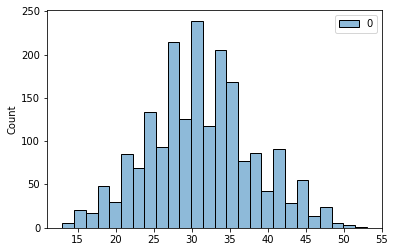

In [9]:
sns.histplot(labels)

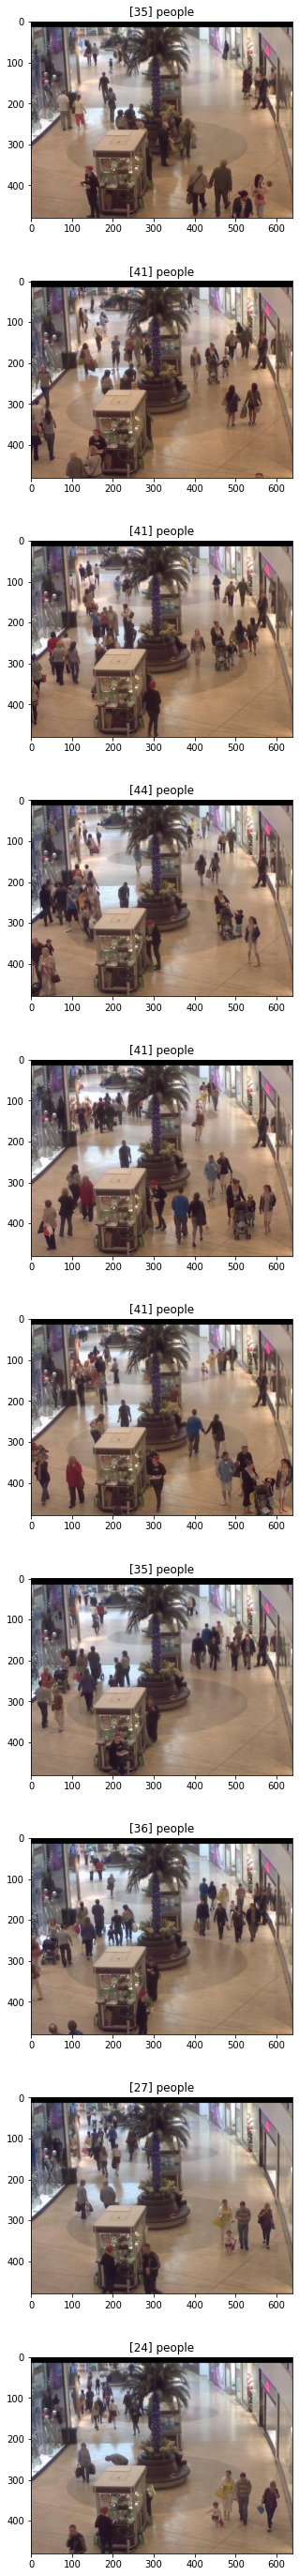

In [10]:
idxs = np.arange(10)
_, ax = plt.subplots(len(idxs), figsize=(5, 5 * len(idxs)))

for i, index in enumerate(idxs):
    ax[i].imshow(images[index])
    ax[i].set_title(f'{labels[index]} people')

# Create train, validation and test sets

In [11]:
images.shape

(2000, 480, 640, 3)

In [12]:
TRAINVAL_SIZE = 0.8
TRAIN_SIZE = 0.8
RANDOM_STATE = 42
SUBSAMPLE_SIZE = 0.3


def print_shapes(arrs_):
    for arr in arrs_:
        print(arr.shape)


X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    images,
    labels,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE
)

X_train, X_validation, Y_train, Y_validation = train_test_split(
    X_trainval,
    Y_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE
)

X_train_subsample, _, Y_train_subsample, _ = train_test_split(
    X_train,
    Y_train,
    train_size=SUBSAMPLE_SIZE,
    random_state=RANDOM_STATE
)

X_validation_subsample, _, Y_validation_subsample, _ = train_test_split(
    X_validation,
    Y_validation,
    train_size=SUBSAMPLE_SIZE,
    random_state=RANDOM_STATE
)

print_shapes(
    [
        X_trainval,
        Y_trainval,
        X_test,
        Y_test,
        X_train,
        Y_train,
        X_validation,
        Y_validation,
        X_train_subsample,
        Y_train_subsample,
        X_validation_subsample,
        Y_validation_subsample
    ]
)

del X_trainval, Y_trainval

(1600, 480, 640, 3)
(1600, 1)
(400, 480, 640, 3)
(400, 1)
(1280, 480, 640, 3)
(1280, 1)
(320, 480, 640, 3)
(320, 1)
(384, 480, 640, 3)
(384, 1)
(96, 480, 640, 3)
(96, 1)


In [13]:
datasets = {
    'train': (X_train, Y_train),
    'validation': (X_validation, Y_validation),
    'test': (X_test, Y_test),
    'train subsample': (X_train_subsample, Y_train_subsample),
    'validation subsample': (X_validation_subsample, Y_validation_subsample)
}

Text(0.5, 1.0, 'Label distribution')

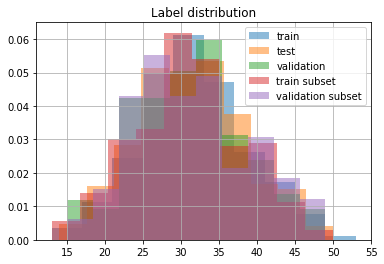

In [14]:
_, ax = plt.subplots()
alpha=0.5


ax.hist(Y_train, density=True, alpha=alpha, label = 'train')
ax.hist(Y_test, density=True, alpha=alpha, label='test')
ax.hist(Y_validation, density=True, alpha=alpha, label='validation')
ax.hist(Y_train_subsample, density=True, alpha=alpha, label='train subset')
ax.hist(Y_validation_subsample, density=True, alpha=alpha, label='validation subset')
ax.grid()
ax.legend()
ax.set_title(f'Label distribution')

# Data exploration (on train set)

(1280, 480, 640, 3)


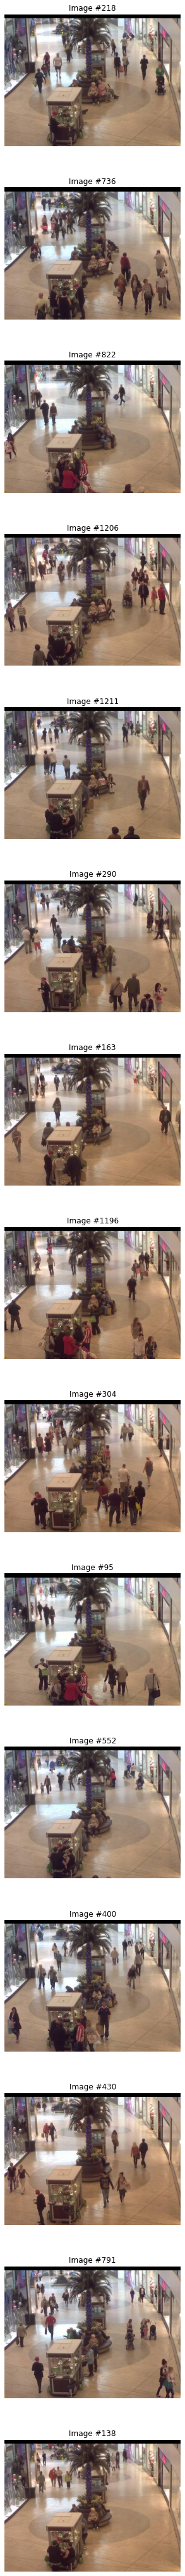

In [15]:
print(X_train.shape)
n_images = 15
indices_subsample = np.random.choice(
    np.arange(X_train.shape[0]), size=n_images, replace=False)

_, ax = plt.subplots(len(indices_subsample), figsize=(5, 5 * len(indices_subsample)))
for i, index in enumerate(indices_subsample):
    ax[i].imshow(X_train[index])
    ax[i].set_title(f'Image #{index}')
    ax[i].axis('off')

In [16]:
np.max(X_train), np.min(X_train)

(255, 0)

# Data preparation

In [55]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input \
    as mobilenet_preprocessing

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_validation, Y_validation))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
train_subsample_dataset = tf.data.Dataset.from_tensor_slices((X_train_subsample, Y_train_subsample))
validation_subsample_dataset = tf.data.Dataset.from_tensor_slices((X_validation_subsample, Y_validation_subsample))

In [56]:
import tensorflow as tf

def scale(x, y):
    return (tf.image.resize(x / 255, size=(224, 224)), y)

train_dataset = train_dataset.map(scale)
validation_dataset = validation_dataset.map(scale)
test_dataset = test_dataset.map(scale)
train_subsample_dataset = train_subsample_dataset.map(scale)
validation_subsample_dataset = validation_subsample_dataset.map(scale)

(224, 224, 3)
(224, 224, 3)


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


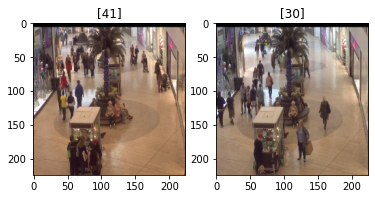

In [58]:
n_images = 2
_, ax = plt.subplots(1, n_images)
counter = 0
for x, y in train_dataset.take(n_images):
    print(x.shape)
    ax[counter].imshow(x)
    ax[counter].set_title(y.numpy())
    counter += 1

# Model preparation

In [59]:
from tensorflow.keras.layers import (
    Input,
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout
)
from tensorflow.keras.models import Sequential
from functools import partial

In [60]:
conv_layer = partial(Conv2D, activation='relu', kernel_initializer='he_normal')
dense_layer = partial(Dense, activation='relu', kernel_initializer='he_normal')

In [61]:
from tensorflow.keras.models import Sequential

baseline = Sequential(
    [
        Input(shape=(224, 224, 3)),
        conv_layer(kernel_size=(5, 5), filters=32),
        conv_layer(kernel_size=(3, 3), filters=64),
        MaxPool2D(pool_size=(2, 2)),
        conv_layer(kernel_size=(3, 3), filters=128),
        conv_layer(kernel_size=(3, 3), filters=256),
        MaxPool2D(pool_size=(2, 2)),
        Flatten(),
        dense_layer(units=100),
        Dropout(0.3),
        dense_layer(units=1)
    ]
)


In [62]:
baseline.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 220, 220, 32)      2432      
                                                                 
 conv2d_33 (Conv2D)          (None, 218, 218, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 109, 109, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 107, 107, 128)     73856     
                                                                 
 conv2d_35 (Conv2D)          (None, 105, 105, 256)     295168    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 52, 52, 256)      0         
 g2D)                                                 

In [63]:
baseline.compile(
    loss='mae',
    optimizer='adam',
    metrics=['mae']
)

In [64]:
train_dataset = train_dataset.shuffle(buffer_size=128).batch(32)

In [65]:
train_dataset.shape

AttributeError: ignored

In [66]:
baseline.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=3,
)

Epoch 1/3
 3/40 [=>............................] - ETA: 14:49 - loss: 155.9394 - mae: 155.9394

KeyboardInterrupt: ignored